# Classification Experiment: Name + Description
---
This Notebook, includes a series of experiments, on using a node's name and description for classification.

Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import json
import tweepy
import time

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib

Twitter API Authentication:

In [2]:
twitter_credentials = []
with open('../../../../twitter_credentials.json', 'r') as f:
    twitter_credentials = json.load(f)

auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'], twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token_key'],twitter_credentials['access_token_secret'])
API = tweepy.API(auth)

Functions:

In [2]:
# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

# Function For Support Vector Machine
def classification_svm(X, y, vect):
    if vect == 'TF-IDF':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('svm', svm.SVC())
        ]
        )
    elif vect == 'BoW':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('svm', svm.SVC())
        ]
        )

    parameters = {'vectorizer__max_df': [0.25, 0.5, 0.75, 1],
                  'vectorizer__min_df': [1, 5, 10, 25],
                  'vectorizer__max_features': [10, 100, 1000, 2000, None],
                  'svm__C' : [0.1,0.5,1,5,10],
                  'svm__kernel':['linear', 'poly', 'rbf', 'sigmoid']
                  }
    
    grid = GridSearchCV(pipeline, parameters, n_jobs = 4)
    grid.fit(X, y)
    
    print(grid.best_params_)
    return grid.best_score_

# Function For Logistic Regression
def classification_lr(X, y, vect):
    if vect == 'TF-IDF':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('lr', LogisticRegression(max_iter=1000))
        ]
        )
    elif vect == 'BoW':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('lr', LogisticRegression(max_iter=1000))
        ]
        )

    parameters = {'vectorizer__max_df': [0.25, 0.5, 0.75, 1],
                  'vectorizer__min_df': [1, 5, 10, 25],
                  'vectorizer__max_features': [10, 100, 1000, 2000, None],
                  'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'lr__C': [0.1, 0.5, 1, 5, 10]
                  }
    
    grid = GridSearchCV(pipeline, parameters, n_jobs = 4)
    grid.fit(X, y)
    
    print(grid.best_params_)
    return grid.best_score_

# Function For kNN
def classification_knn(X, y, vect):
    if vect == 'TF-IDF':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('knn', KNeighborsClassifier())
        ]
        )
    elif vect == 'BoW':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('knn', KNeighborsClassifier())
        ]
        )

    parameters = {'vectorizer__max_df': [0.25, 0.5, 0.75, 1],
                  'vectorizer__min_df': [1, 5, 10, 25],
                  'vectorizer__max_features': [10, 100, 1000, 2000, None],
                  'knn__n_neighbors': [1,2,3,4,5,6,7,8,9,10],
                  'knn__weights': ['uniform', 'distance']
                  }
    
    grid = GridSearchCV(pipeline, parameters, n_jobs = 4)
    grid.fit(X, y)
    
    print(grid.best_params_)
    return grid.best_score_


# Dataset
---

To begin with, we read our datasets, and fetch some tweets for each node creating 3 new fields:
- recent_tweet
- recent_10_tweets
- recent_100_tweets

In [3]:
# Read Training Set
training_set = pd.read_csv('../../../../datasets/Greek Politicians/classification/parliament_members_training_set.csv', 
                           usecols=['screen_name', 'name', 'description', 'parliament_member'])
training_set = training_set.replace(np.nan, '')

In [4]:
training_set.head()

,screen_name,name,description,parliament_member
0,evefthym,Ευάγγελος Ευθυμίου,Καναλάκι \nΠάργα \nΙωάννινα,0
1,Qdv6zNFe0nkBH2m,Χριστίνα Κεραμεως,Χιούμορ,0
2,michail_pana,Μιχαήλ Παναγιωτόπουλος,Απόστρατος Ναύαρχος του Πολέμικού Ναυτικού.\nΜ...,0
3,spirtzisforever,Χρήστος not Σπίρτζης,Parody account/Fan account του πιο ερωτικού βο...,0
4,FdZwMqKWXciTydT,Ειρήνη Γκαρα,,0


# Case 1: name + description 
---
In this case, we use a node's name and description  as a single feature to classify the node.

## Text Normalization
We start by creating a new field:
- textdata : name + description

In [10]:
data = training_set.copy()
data['textdata_1'] = data['name'] + ' ' + data['description']
data = data.drop(['name', 'description'], axis = 1)
data.head(3)

,screen_name,parliament_member,textdata_1
0,evefthym,0,Ευάγγελος Ευθυμίου Καναλάκι \nΠάργα \nΙωάννινα
1,Qdv6zNFe0nkBH2m,0,Χριστίνα Κεραμεως Χιούμορ
2,michail_pana,0,Μιχαήλ Παναγιωτόπουλος Απόστρατος Ναύαρχος του...


Next normalize our text by taking the following actions:

- remove URLs
- remove Mentions
- remove anything that isn't a unicode character (e.g emojis, punctuation)
- remove numbers and _
- fix whitespace
- convert to lower case

In [11]:
data['textdata_1'] = clean_text(data['textdata_1'])

## Model Selection

In [19]:
svm_tfidf = pd.DataFrame()
svm_bow = pd.DataFrame()

lr_tfidf = pd.DataFrame()
lr_bow = pd.DataFrame()

knn_tfidf = pd.DataFrame()
knn_bow = pd.DataFrame()

### Without NLP

In [20]:
textdatas = ['textdata_1']

#### SVM

In [21]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_svm(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64 0.64 0.64 ...  nan  nan  nan]
  warnings.warn(


,textdata_1
Without NLP,0.91


In [22]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_svm(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.66666667 0.66666667 0.66333333 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8867


#### Logistic Regression

In [23]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_lr(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.9033


In [24]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_lr(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 5, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.8933


#### kNN

In [25]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_knn(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70333333 0.70333333 0.69666667 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.87


In [26]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_knn(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 6, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68333333 0.68333333 0.68333333 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8667


### Stop Word Removal

In [8]:
nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

In [13]:
df = data.copy()

df['textdata_1'] = df['textdata_1'].apply(lambda row: remove_stopwords(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: ' '.join(row))

#### SVM

In [29]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69333333 0.69       0.69333333 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.9100
Stopword Removal,0.9067


In [30]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65666667 0.65       0.65       ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8867
Stopword Removal,0.9067


#### Logistic Regression

In [31]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.9033
Stopword Removal,0.9100


In [32]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 5, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.8933
Stopword Removal,0.8967


#### kNN

In [33]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73       0.72333333 0.72333333 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8700
Stopword Removal,0.8933


In [34]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72 0.71 0.71 ...  nan  nan  nan]
  warnings.warn(


,textdata_1
Without NLP,0.8667
Stopword Removal,0.8900


### Lemmatization

In [9]:
def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

In [15]:
df = data.copy()

df['textdata_1'] = df['textdata_1'].apply(lambda row: tokenize_lemmatize(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: ' '.join(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: remove_stopwords(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: ' '.join(row))

#### SVM

In [37]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65666667 0.66666667 0.66666667 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.9100
Stopword Removal,0.9067
Lemmatization,0.9100


In [38]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62333333 0.61333333 0.61666667 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8867
Stopword Removal,0.9067
Lemmatization,0.9000


#### Logistic Regression

In [39]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.9033
Stopword Removal,0.9100
Lemmatization,0.9133


In [40]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 5, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.8933
Stopword Removal,0.8967
Lemmatization,0.8933


#### kNN

In [41]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74       0.73666667 0.72666667 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8700
Stopword Removal,0.8933
Lemmatization,0.8933


In [42]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)
knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72       0.72333333 0.70666667 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8667
Stopword Removal,0.8900
Lemmatization,0.8833


### Short Word Removal

In [43]:
df_2 = df.copy()

In [44]:
def remove_shortwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if len(w) > 2]

In [45]:
df_2['textdata_1'] = df_2['textdata_1'].apply(lambda row: remove_shortwords(row))
df_2['textdata_1'] = df_2['textdata_1'].apply(lambda row: ' '.join(row))

#### SVM

In [46]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.66       0.65333333 0.66333333 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.9100
Stopword Removal,0.9067
Lemmatization,0.9100
Short Word Removal,0.9067


In [47]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'svm__C': 0.5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61333333 0.61666667 0.61       ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8867
Stopword Removal,0.9067
Lemmatization,0.9000
Short Word Removal,0.8967


#### Logistic Regression

In [48]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.9033
Stopword Removal,0.9100
Lemmatization,0.9133
Short Word Removal,0.9067


In [49]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'lr__C': 10, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


,textdata_1
Without NLP,0.8933
Stopword Removal,0.8967
Lemmatization,0.8933
Short Word Removal,0.8900


#### kNN

In [50]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72666667 0.72666667 0.69666667 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8700
Stopword Removal,0.8933
Lemmatization,0.8933
Short Word Removal,0.8833


In [52]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for textdata_1:
{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72333333 0.72       0.69333333 ...        nan        nan        nan]
  warnings.warn(


,textdata_1
Without NLP,0.8667
Stopword Removal,0.8900
Lemmatization,0.8833
Short Word Removal,0.8800
Short Word Removal,0.8800


## Irrelevant Word Removal

Text(0.5, 1.0, 'Not-Pol')

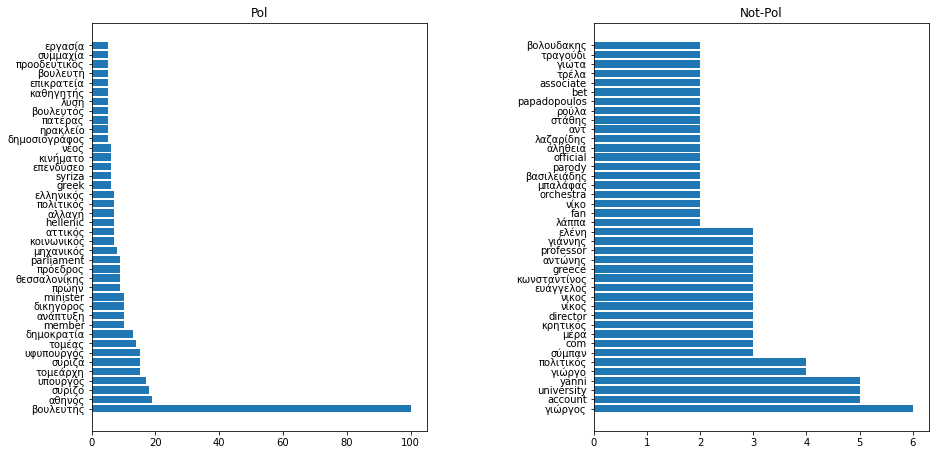

In [54]:
pol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 1].textdata_1).split()).value_counts()
nonpol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 0].textdata_1).split()).value_counts()

fig, axs = plt.subplots(1,2,figsize =(15,7.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5)

axs[0].barh(pol_words[:40].index, pol_words[:40])
axs[0].set_title('Pol')
axs[1].barh(nonpol_words[:40].index, nonpol_words[:40])
axs[1].set_title('Not-Pol')

## Export Model

- TF-IDF outperformed BoW for each classifer and processing step
- Logistic Regression and Support Vector Machines seem to have a similar performance, kNN on the other hand does not perform that well.
- A processing step does not necassarily increase the performance<br>
<br>

The best model we found is: Logistic Regression-TF-IDF
- vectorizer__max_df: 0.5
- vectorizer__max_features: 2000
- vectorizer__min_df: 1
- lr__C: 0.1
- lr__penalty: l2<br>

with the following NLP steps:
- Lemmatization
- Stop Word Removal





In [10]:
def get_text_data_parl_nd(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata


get_text = FunctionTransformer(get_text_data_parl_nd)

In [11]:
pipeline = Pipeline([
    ('selector', get_text),
    ('tfidf', TfidfVectorizer(max_df=0.5, max_features=2000, min_df=1)),
    ('lr', LogisticRegression(max_iter=1000, C=0.1, penalty = 'l2'))
])

In [12]:
X = training_set
y = training_set['parliament_member']
pipeline.fit(X,y)

Pipeline(steps=[('selector',
                 FunctionTransformer(func=<function get_text_data_parl_nd at 0x7f8e62374160>)),
                ('tfidf', TfidfVectorizer(max_df=0.5, max_features=2000)),
                ('lr', LogisticRegression(C=0.1, max_iter=1000))])

In [13]:
filename = 'classifier_parl_nd.sav'
joblib.dump(pipeline, filename)

['classifier_parl_nd.sav']